<a href="https://colab.research.google.com/github/alleyex/tensorflow_lab/blob/main/using_convolutions_with_lstms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
  """
  Visualizes time series data
  Args:
    x (array of int): contains values for the x-axis
    y (array of int or tuple of arrays): contains values for the y-axis
    format (string): line style when plotting the graph
    start (int): first time step to plot
    end (int): last time step to plot
    title (string): title of the plot
    xlabel (string): label for the x-axis
    ylabel (string): label for the y-axis
    legend (string): legend for the plot
  """

  # Setup dimensions of the graph figure
  plt.figure(figsize=(10, 6))

  # Check if there are more than two series to plot
  if type(y) is tuple:

    # Loop over the y elements
    for y_curr in y:

      # plot the x and current y values
      plt.plot(x[start: end], y_curr[start: end], format)

  else:
    plt.plot(x[start: end], y[start: end], format)

  # Label the x-axis
  plt.xlabel(xlabel)

  # Label the y-axis
  plt.ylabel(ylabel)

  # Set the title
  plt.title(title)

  # Overlay a grid on the graph
  plt.grid(True)

  # Draw the graph on screen
  plt.show()

def trend(time, slope=0):
  """
  Generates synthetic data that follows a straight line given slope and time

  Args:
    time (array of int): contains the time steps
    slope (float): slope of the line

  Returns:
    series (array of float): the synthetic series
  """

  # compute the linear series given the slope
  series = slope * time

  return series

def seasonal_pattern(season_time):
  """
  Just an arbitrary pattern, you can change it if you wish

  Args:
    season_time (array of float): contains the measurements per time step

  Returns:
    data_pattern (array of float): contains revised measurements values according to the defined pettern
  """

  # Generate the values using an arbitrary pattern
  data_pattern = np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

  return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeats the same pattern at each period

  Args:
    time (array of int): contains the time steps
    period (int): number of time steps before the pattern repeats
    amplitude (float): peak measured value in a period
    phase (float): number of time steps to shift the measurement values

  Returns:
    data_pattern (array of float): seasonal data scaled by the defined amplitude
  """

  # Compute the measured values per period
  season_time = ((time + phase) % period) / period

  # Generates the seasonal data scaled by the defined amplittude
  data_pattern = amplitude * seasonal_pattern(season_time)

  return data_pattern

def noise(time, noise_level=1, seed=None):
  """
  Generates a synthetic noise signal

  Args:
    time (array of int): contains the time steps
    noise_level (float): scaling factor for the generated signal
    seed (int): number generator seed for repeatability

  Returns:
    noise (array of float): the noisy signal
  """

  # Initialize the random number generator
  rnd = np.random.RandomState(seed)

  # Generate a random number for each time step and scale by the noise level
  noise = rnd.randn(len(time)) * noise_level

  return noise


In [ ]:
# Generate the Synthetic Data
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel="Time", ylabel="Value")

In [7]:
# Split the Dataset
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
# Prepare features and labels
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows

  Args:
    series (array of float): contains the values of the time series
    window_size (int): the number of time steps to average
    batch_size (int): the batch size
    shuffle_buffer (int): buffer size to use for the shuffle method

  Returns:
    dataset (tf.data.Dataset): TF dataset containing time windows
  """

  # Create a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size +1, shift=1, drop_remainder=True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # create tuples with features and labels
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [13]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [ ]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "causal", activation = "relu", input_shape = [window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
    ])

# Print the model summary
model.summary()

In [18]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

#  Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])


(1e-08, 0.001, 0.0, 30.0)

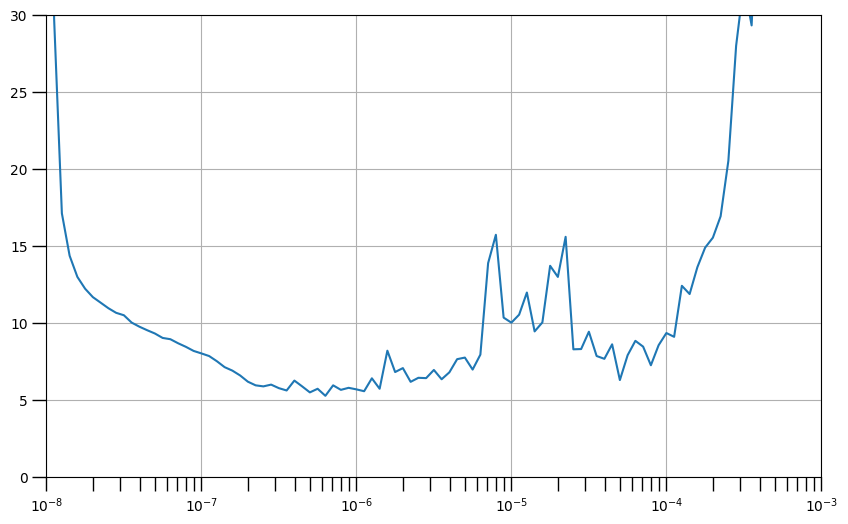

In [22]:
# Define the learning rate array
lrs = 1e-8 * (10**(np.arange(100) /20))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params(axis = 'both', length = 10, width = 1, which = 'both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])


In [23]:
# Set the learning rate
learning_rate = 4e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])


In [ ]:
# Train the model
history = model.fit(train_set, epochs = 500)

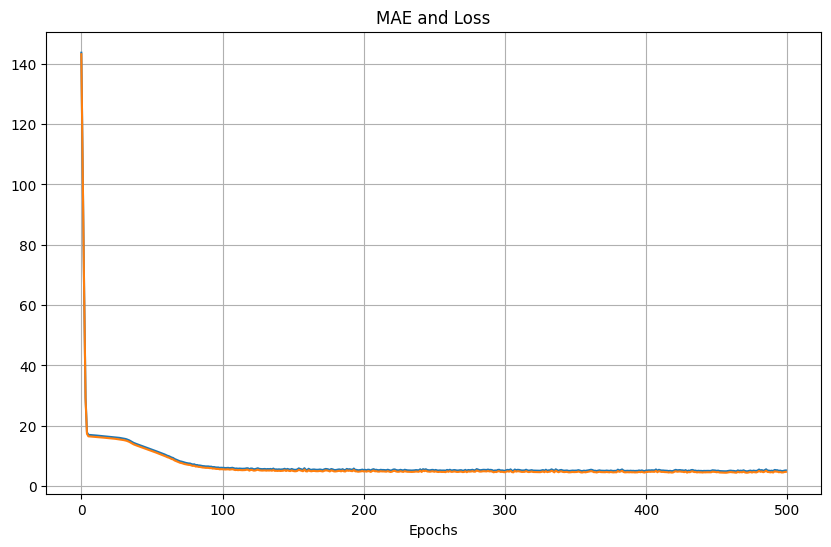

In [29]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(x = epochs, y = (mae, loss), title = "MAE and Loss", xlabel = "Epochs", legend = ["MAE", "Loss"])


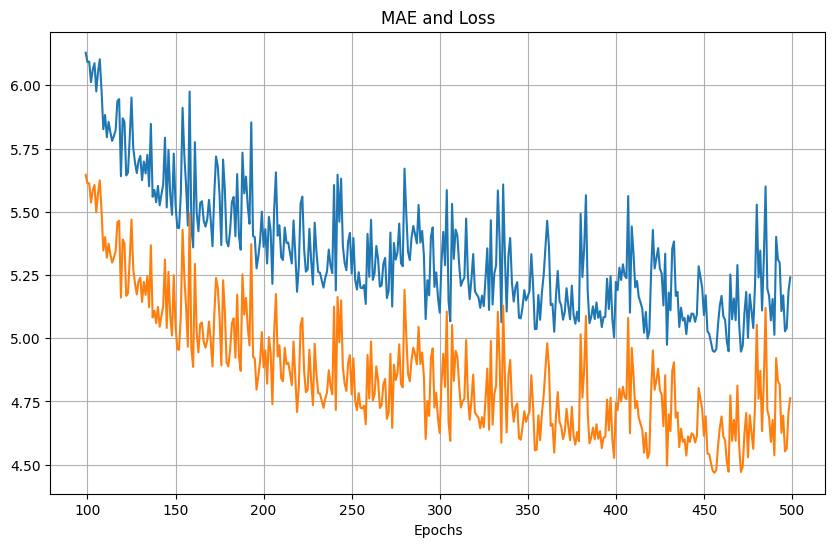

In [32]:
# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(x = epochs_zoom, y = (mae_zoom, loss_zoom), title = "MAE and Loss", xlabel = "Epochs", legend = ["MAE", "Loss"])


In [34]:
def model_forecast(model, series, window_size, batch_size):
  """
  Uses an input model to generate predictions on data windows

  Args:
    model (tf.keras.Model): model that accepts data windows
    series (array of float): contains the values of the time series
    window_size (int): the number of time steps to include in the window
    batch_size (int): the batch size

  Returns:
    forecast (numpy array): array containing predictions
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size, shift=1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  # Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast


29/29 [==============================] - 2s 13ms/step


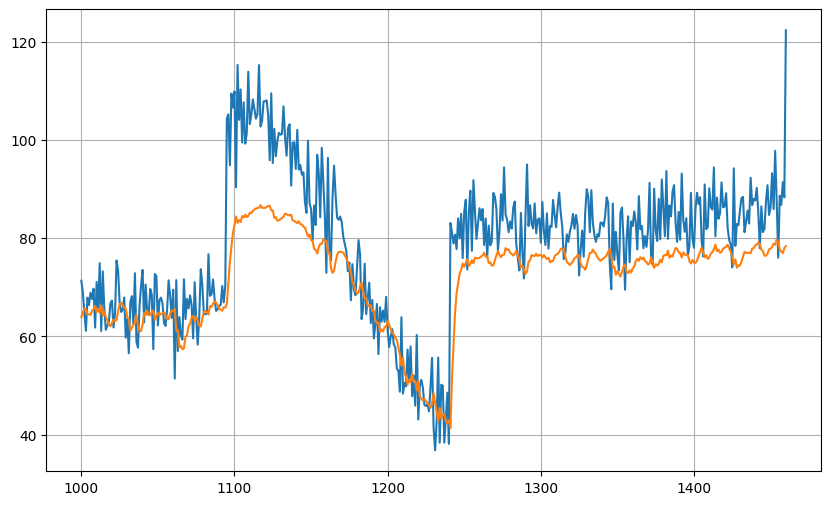

In [35]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
forecast = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, forecast))

In [37]:
# Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy())

111.59717
8.109092


In [41]:
# Adding a Callback for Early Stopping
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Initialize the early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [42]:
# Uncomment if you want to reset the weights
# model.set_weights(init_weights)

In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    """
    Halts the training when a certaion metric is met
    Args:
      epoch (int): index of epoch (required but unused in the function definition below)
      logs (dict): metrics results from training epoch
    """

    # Check the validation set MAE
    if logs.get('val_mae') < 5.2:
      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()


In [ ]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics =['mae'])

# Train the model
history = model.fit(train_set, epochs = 500, validation_data = val_set, callbacks = [callbacks])

29/29 [==============================] - 1s 8ms/step


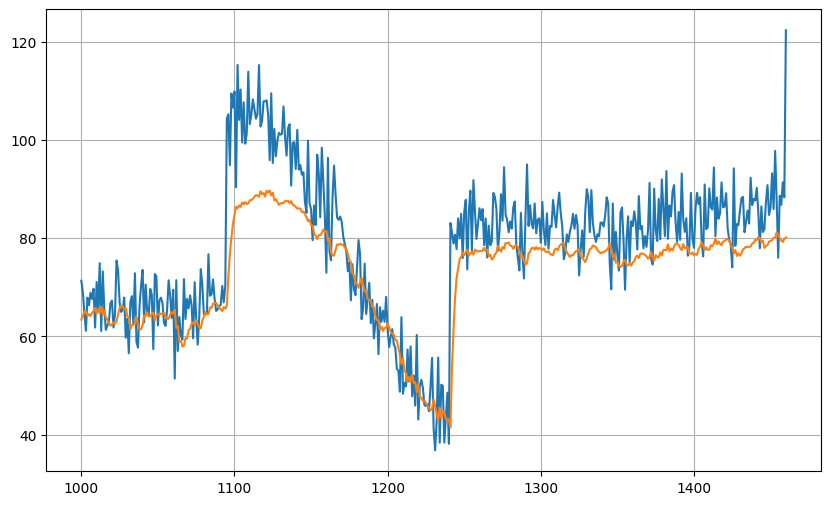

In [47]:
# Reduec the original series
forecast_series = series[split_time - window_size: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [48]:
# Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

89.12082
7.1198077
